# 1. Instalando as bibliotecas

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 2. Leitura dos dados

In [3]:
dados = pd.read_csv('dados_operacoes.csv', sep = ',')
dados.head()

,id,contrato,data_operacao,nascimento,idade,genero,bairro,cidade,estado,cep,...,empregador,operacao,valor_principal,parcelas,quantidade_parcelas,parcelas_pagas,quantidade_parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto
0,682e8b505c30bb12052f9457516dc47e7eafc8ed,1760865030954,2019-09-13,1974-06-08,48,F,Conjunto Paulo Vi,Moreira,Rio de Janeiro,XXXXX-685,...,e53d5342e82e0ce6061bc3aaea1a986f24a73613,Prod,27810.69,100,100,20,20,1.46493,531.56,53156.0000
1,45ad9d444a276407df8b6f47c0fcc5b127dadaaa,6023030871505,2022-11-03,1988-07-23,34,F,Minas Caixa,da Mota de Azevedo,Amapá,XXXXX735,...,f715ffaf2c8294df43df3357c6a37f04b900fb06,Refin,9589.96,40,40,6,6,4.53587,523.82,20952.8000
2,81cec74ea2ca41535fee03daeb410ddbdf12906a,560263027614,2021-06-13,1975-08-17,Null,Null,Vila Mantiqueira,Rocha da Prata,Santa Catarina,XXXXX863,...,da9515ffa45dd12791be0941b91188e51fe1cc04,Prod,42963.20,100,100,10,10,1.44749,815.71,81571.0000
3,4e987d9178e2dcb07c2bf3878736233a676a0a87,1397061435926,2021-08-30,1982-08-17,40,F,Anchieta,da Mata,Null,Null,...,0c1741dc26339e6af3e4b6badcf984d383d1ca44,Port + Refin,2954.14,120,120,6,6,1.82904,60.96,7315.1997
4,595943ecdb32a24ccb6ef374b6d865f3b60d7130,3823566005671,2022-11-16,1985-07-14,37,F,Conjunto Floramar,Moreira de Goiás,Mato Grosso,XXXXX384,...,f97b240dc24290c19e717d7a654747aa31722ad3,Prod,31186.17,100,100,10,10,3.28340,1066.11,106611.0000


A partir de uma observação das primeiras linhas da nossa base de dados, podemos observar algumas variáveis categorizadas como "Null" em nossos dados, veremos se é possivel fazer um tratamento nelas logo a frente

In [4]:
dados.shape

(14895, 24)

# 3. Analise Inicial dos dados

Verificando padrão dos dados e algumas estatísticas das variáveis 

## 3.1 Verificando as estatísticas do teste e o formato do dataframe

In [5]:
dados.describe()

,contrato,valor_principal,parcelas,quantidade_parcelas,parcelas_pagas,quantidade_parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto
count,1.489500e+04,14895.000000,14895.000000,14895.000000,14895.000000,14895.000000,14895.000000,14895.000000,14895.000000
mean,4.986736e+12,23185.875466,68.224236,68.224236,15.739040,15.739040,2.134701,724.267448,47446.568597
std,2.894235e+12,13500.843754,27.128264,27.128264,17.519803,17.519803,1.341172,515.074503,39877.201593
min,7.105632e+08,203.550000,40.000000,40.000000,0.000000,0.000000,0.347370,3.050000,252.400000
25%,2.466882e+12,12484.045000,40.000000,40.000000,6.000000,6.000000,1.023490,336.700000,20689.500000
50%,4.964680e+12,20256.790000,60.000000,60.000000,9.000000,9.000000,1.793700,601.640000,38220.000000
75%,7.513420e+12,34651.280000,90.000000,90.000000,18.000000,18.000000,3.019275,1007.655000,61545.198000
max,9.999785e+12,49995.020000,120.000000,120.000000,108.000000,108.000000,6.461680,3063.990000,367678.800000


In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14895 entries, 0 to 14894
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         14895 non-null  object 
 1   contrato                   14895 non-null  int64  
 2   data_operacao              14895 non-null  object 
 3   nascimento                 14895 non-null  object 
 4   idade                      14895 non-null  object 
 5   genero                     14895 non-null  object 
 6   bairro                     14895 non-null  object 
 7   cidade                     14895 non-null  object 
 8   estado                     14895 non-null  object 
 9   cep                        14895 non-null  object 
 10  telefone                   14895 non-null  object 
 11  cartao                     14895 non-null  object 
 12  email                      14895 non-null  object 
 13  ocupacao                   14895 non-null  obj

A base de dados está identificando os valores classificados como "Null" como uma string apenas, vamos removê-las dos nossos dados mais à frente

In [7]:
# Verificando a quantidade de valores distintos em cada variável
dados.nunique()

id                            4998
contrato                     14895
data_operacao                 1457
nascimento                    4099
idade                           34
genero                           3
bairro                         483
cidade                        1533
estado                          28
cep                           1782
telefone                      4285
cartao                        3910
email                         5957
ocupacao                       747
empregador                    1597
operacao                         3
valor_principal              14875
parcelas                         6
quantidade_parcelas              6
parcelas_pagas                  37
quantidade_parcelas_pagas       37
taxa_contrato                14626
valor_parcela                14227
valor_bruto                  14571
dtype: int64

## 3.2 Tratando os valores Null

Vimos na leitura de tabela inicial que os dados possuem valores nulls, porém eles estão em formato de string, entao iremos transformar em null values, depois fazemos a contagem de nulos e a proporçao deles em relação ao total

In [8]:
dados.replace("Null", pd.NaT, inplace = True)

In [9]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14895 entries, 0 to 14894
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         14895 non-null  object 
 1   contrato                   14895 non-null  int64  
 2   data_operacao              14895 non-null  object 
 3   nascimento                 14895 non-null  object 
 4   idade                      11890 non-null  object 
 5   genero                     13408 non-null  object 
 6   bairro                     12356 non-null  object 
 7   cidade                     12064 non-null  object 
 8   estado                     12661 non-null  object 
 9   cep                        11141 non-null  object 
 10  telefone                   10240 non-null  object 
 11  cartao                     9616 non-null   object 
 12  email                      10228 non-null  object 
 13  ocupacao                   12624 non-null  obj

In [10]:
# Calculando valores quantidade de valores nulls

valores_ausentes = dados.isnull().sum()
print(valores_ausentes)

id                              0
contrato                        0
data_operacao                   0
nascimento                      0
idade                        3005
genero                       1487
bairro                       2539
cidade                       2831
estado                       2234
cep                          3754
telefone                     4655
cartao                       5279
email                        4667
ocupacao                     2271
empregador                   3124
operacao                        0
valor_principal                 0
parcelas                        0
quantidade_parcelas             0
parcelas_pagas                  0
quantidade_parcelas_pagas       0
taxa_contrato                   0
valor_parcela                   0
valor_bruto                     0
dtype: int64


In [11]:
print((dados.isnull().sum()/(len(dados)))*100) # Calculando a porcentagem de valores nulos

id                            0.000000
contrato                      0.000000
data_operacao                 0.000000
nascimento                    0.000000
idade                        20.174555
genero                        9.983216
bairro                       17.045989
cidade                       19.006378
estado                       14.998322
cep                          25.203088
telefone                     31.252098
cartao                       35.441423
email                        31.332662
ocupacao                     15.246727
empregador                   20.973481
operacao                      0.000000
valor_principal               0.000000
parcelas                      0.000000
quantidade_parcelas           0.000000
parcelas_pagas                0.000000
quantidade_parcelas_pagas     0.000000
taxa_contrato                 0.000000
valor_parcela                 0.000000
valor_bruto                   0.000000
dtype: float64


Podemos observar uma grande quantidade de dados nulos bem espalhada em nossa base de dados, para contornar tal problema, poderiamos completa-los, utilizando a mediana ou a média das observaçoes caso houvessem poucos nulos, em nosso caso, por ser haver diversos nulos espalhados em diversas colunas, e tambem devido a origem do problema proposto, iremos remover as colunas com nulos e utilizar apenas algumas colunas de interesse ao nosso modelo 

# 3. Manipulação da base de dados e análise das variáveis

Como observamos no ultimo tópico, iremos utilizar apenas algumas variáveis para o nosso problema, faremos entao a seleção dessas variáveis e as analizaremos, verificando suas distribuições e possiveis outros problemas na estruturação e distribuição das variáveis

## 3.1 Selecionando as variáveis de interesse

Como o problema proposto é um problema de forecasting, precisamos utilizar apenas as variáveis de tempo e nossas targets, temos como alvo o volume e o valor da carteira, entao iremos selecionar essas variáveis

In [12]:
columns_to_keep = ['data_operacao','valor_principal', 'valor_bruto']
columns_to_drop = [i for i in dados.columns if i not in columns_to_keep]

print(columns_to_drop)

['id', 'contrato', 'nascimento', 'idade', 'genero', 'bairro', 'cidade', 'estado', 'cep', 'telefone', 'cartao', 'email', 'ocupacao', 'empregador', 'operacao', 'parcelas', 'quantidade_parcelas', 'parcelas_pagas', 'quantidade_parcelas_pagas', 'taxa_contrato', 'valor_parcela']


In [13]:
dados.drop(columns=columns_to_drop, axis=1, inplace=True)

In [14]:
dados.shape

(14895, 3)

In [15]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14895 entries, 0 to 14894
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   data_operacao    14895 non-null  object 
 1   valor_principal  14895 non-null  float64
 2   valor_bruto      14895 non-null  float64
dtypes: float64(2), object(1)
memory usage: 349.2+ KB


In [16]:
dados_aux = dados.copy()

## 3.2 Transformando a variável de tempo no formato datetime

In [17]:
dados['data_operacao'] = pd.to_datetime(dados.data_operacao, format='%Y-%m-%d')

In [18]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14895 entries, 0 to 14894
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data_operacao    14895 non-null  datetime64[ns]
 1   valor_principal  14895 non-null  float64       
 2   valor_bruto      14895 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 349.2 KB


## 3.3 Agrupando valores por data para obter o valor principal e bruto total por dia e o volume de operações por dia

In [19]:
dados = dados.groupby(['data_operacao']).sum().reset_index()

In [20]:
dados['qtd_op'] = dados_aux.groupby('data_operacao').count().reset_index()['valor_principal']
dados

,data_operacao,valor_principal,valor_bruto,qtd_op
0,2019-01-01,107663.77,1.861155e+05,6
1,2019-01-02,226089.48,3.736158e+05,10
2,2019-01-03,210935.84,3.450784e+05,12
3,2019-01-04,85949.57,1.503219e+05,7
4,2019-01-05,95787.24,1.600302e+05,6
...,...,...,...,...
1452,2022-12-26,160835.74,6.118084e+05,8
1453,2022-12-27,331690.99,1.131008e+06,16
1454,2022-12-28,299305.49,9.200780e+05,11
1455,2022-12-29,325785.43,8.180298e+05,16


## 3.4 Verificando a série temporal para "valor_principal", "valor_bruto" e "qtd_op"

<Axes: xlabel='data_operacao'>

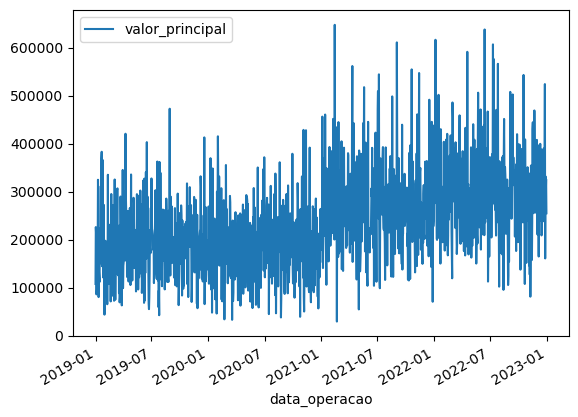

In [21]:
dados.plot(x="data_operacao", y="valor_principal")

<Axes: xlabel='data_operacao'>

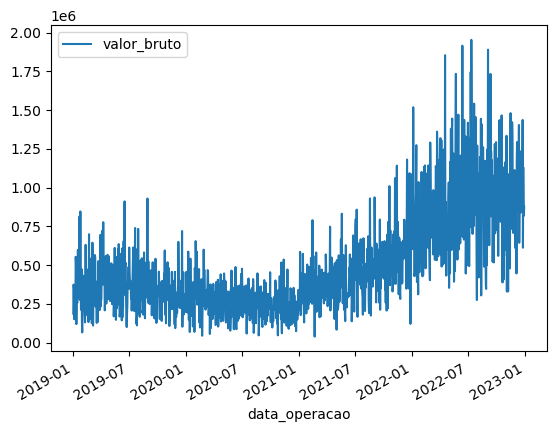

In [22]:
dados.plot(x="data_operacao", y="valor_bruto")

<Axes: xlabel='data_operacao'>

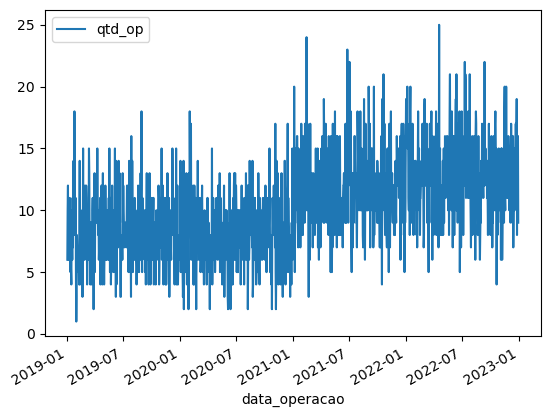

In [23]:
dados.plot(x="data_operacao", y="qtd_op")

Vemos que tanto a variável "qtd_op" quanto a variável "valor_principal" seguem um padrao parecido

In [24]:
## 3.5 Criando variáveis relacionados a data para ajudar em nosso modelo de série temporal

In [25]:
dados["dia"] = dados["data_operacao"].dt.day
dados["mes"] = dados["data_operacao"].dt.month
dados["ano"] = dados["data_operacao"].dt.year
dados["dia_da_semana"] = dados["data_operacao"].dt.dayofweek

dados.head()

,data_operacao,valor_principal,valor_bruto,qtd_op,dia,mes,ano,dia_da_semana
0,2019-01-01,107663.77,186115.500,6,1,1,2019,1
1,2019-01-02,226089.48,373615.800,10,2,1,2019,2
2,2019-01-03,210935.84,345078.399,12,3,1,2019,3
3,2019-01-04,85949.57,150321.898,7,4,1,2019,4
4,2019-01-05,95787.24,160030.200,6,5,1,2019,5


In [26]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data_operacao    1457 non-null   datetime64[ns]
 1   valor_principal  1457 non-null   float64       
 2   valor_bruto      1457 non-null   float64       
 3   qtd_op           1457 non-null   int64         
 4   dia              1457 non-null   int32         
 5   mes              1457 non-null   int32         
 6   ano              1457 non-null   int32         
 7   dia_da_semana    1457 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(1)
memory usage: 68.4 KB


In [27]:
dados.shape

(1457, 8)

# 4. Criando dados de treino e teste 

Como tratamos com um problema de série temporal, não podemos fazer nossa separação de treino e teste de forma aleatória, 

In [28]:
print(dados['data_operacao'].min())
print(dados['data_operacao'].max())
print((dados['data_operacao'].max() - dados['data_operacao'].min()).days)

2019-01-01 00:00:00
2022-12-30 00:00:00
1459


Separamos os dados com datas menores que 31/03/22 pra treino (aproximadamente 80% dos dados) e dados com datas maiores que 01/04/22 pra testarmos nosso modelo

In [29]:
train = dados[dados['data_operacao'].between("2019-01-01","2022-03-31")] #~10^6 linhas!
test  = dados[dados['data_operacao'].between("2022-04-01","2022-12-30")]

In [30]:
print(train.shape)
print(test.shape)

(1183, 8)
(274, 8)


In [31]:
train.head()

,data_operacao,valor_principal,valor_bruto,qtd_op,dia,mes,ano,dia_da_semana
0,2019-01-01,107663.77,186115.500,6,1,1,2019,1
1,2019-01-02,226089.48,373615.800,10,2,1,2019,2
2,2019-01-03,210935.84,345078.399,12,3,1,2019,3
3,2019-01-04,85949.57,150321.898,7,4,1,2019,4
4,2019-01-05,95787.24,160030.200,6,5,1,2019,5


## 4.1 Separando as features das colunas de target 

In [32]:
X_train = train[["dia", "mes", "ano", "dia_da_semana"]]
y_train = train["valor_principal"]
y_train_bruto = train["valor_bruto"] 
y_train_qtd = train["qtd_op"] 

X_test = test[["dia", "mes", "ano", "dia_da_semana"]]
y_test = test["valor_principal"]
y_test_bruto = test["valor_bruto"] 
y_test_qtd = test["qtd_op"]

In [33]:
X_train

,dia,mes,ano,dia_da_semana
0,1,1,2019,1
1,2,1,2019,2
2,3,1,2019,3
3,4,1,2019,4
4,5,1,2019,5
...,...,...,...,...
1178,27,3,2022,6
1179,28,3,2022,0
1180,29,3,2022,1
1181,30,3,2022,2


In [34]:
print(X_train.shape)
print(y_train.shape)
print(y_train_bruto.shape)
print(y_train_qtd.shape)

print(X_test.shape)
print(y_test.shape)
print(y_test_bruto.shape)
print(y_test_qtd.shape)


(1183, 4)
(1183,)
(1183,)
(1183,)
(274, 4)
(274,)
(274,)
(274,)


# 5. Criando modelo XGBoost

## 5.1 XGBoost para "valor_principal"

In [35]:
# XGBoost

cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
modelo = xgb.XGBRegressor()
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}


grid_search = GridSearchCV(estimator=modelo, cv=cv_split, param_grid=params)
grid_search.fit(X_train, y_train)
melhores_params = grid_search.best_params_

print("Best set of hyperparameters: ", melhores_params)

Best set of hyperparameters:  {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1}


In [36]:
xgb_model = xgb.XGBRegressor(**melhores_params)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
predictions = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)

rmse = np.sqrt(mean_squared_error(y_test, predictions))

mae

75805.19147810219

### 5.1.1 Predizendo o futuro

In [38]:
future = pd.Series(pd.date_range("2023", freq="D", periods=365*2))
future_df = pd.DataFrame({'Date': future})
future_df["dia"] = future_df["Date"].dt.day
future_df["mes"] = future_df["Date"].dt.month
future_df["ano"] = future_df["Date"].dt.year
future_df["dia_da_semana"] = future_df["Date"].dt.dayofweek
X_all = future_df[['dia', 'mes', 'ano', 'dia_da_semana']]

In [39]:
predictions = xgb_model.predict(X_all)
predictions

array([290420.3 , 280711.44, 277859.6 , 281195.28, 281195.28, 281195.28,
       281195.28, 281195.28, 277859.6 , 277457.7 , 281396.34, 281396.34,
       268287.1 , 268287.1 , 268287.1 , 264951.38, 264951.38, 270991.8 ,
       270991.8 , 267018.7 , 262710.7 , 262710.7 , 263683.  , 263683.  ,
       267018.7 , 260201.78, 255000.48, 249377.44, 249377.44, 252910.78,
       252910.78, 290420.3 , 284047.16, 281195.28, 281195.28, 281195.28,
       277859.6 , 277859.6 , 281195.28, 281195.28, 280793.38, 281396.34,
       281396.34, 264951.38, 264951.38, 268287.1 , 268287.1 , 268287.1 ,
       270991.8 , 270991.8 , 263683.  , 263683.  , 267018.7 , 267018.7 ,
       267018.7 , 262710.7 , 253332.73, 252910.78, 252910.78, 290420.3 ,
       284047.16, 281195.28, 281195.28, 281195.28, 277859.6 , 277859.6 ,
       281195.28, 281195.28, 280793.38, 281396.34, 281396.34, 264951.38,
       264951.38, 268287.1 , 268287.1 , 268287.1 , 270991.8 , 270991.8 ,
       263683.  , 263683.  , 267018.7 , 267018.7 , 

In [40]:
predictions.shape

(730,)

In [41]:
future

0     2023-01-01
1     2023-01-02
2     2023-01-03
3     2023-01-04
4     2023-01-05
         ...    
725   2024-12-26
726   2024-12-27
727   2024-12-28
728   2024-12-29
729   2024-12-30
Length: 730, dtype: datetime64[ns]

In [42]:

df_final = pd.DataFrame({'Date': future, 'Predictions': predictions})
print(df_final)

          Date    Predictions
0   2023-01-01  290420.312500
1   2023-01-02  280711.437500
2   2023-01-03  277859.593750
3   2023-01-04  281195.281250
4   2023-01-05  281195.281250
..         ...            ...
725 2024-12-26  258777.484375
726 2024-12-27  253576.171875
727 2024-12-28  247953.140625
728 2024-12-29  247953.140625
729 2024-12-30  251486.468750

[730 rows x 2 columns]


## 5.2 XGBoost para "valor_bruto"

In [43]:
# XGBoost

cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
modelo = xgb.XGBRegressor()
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}


grid_search = GridSearchCV(estimator=modelo, cv=cv_split, param_grid=params)
grid_search.fit(X_train, y_train_bruto)
melhores_params = grid_search.best_params_

print("Best set of hyperparameters: ", melhores_params)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7}


In [44]:
y_test_bruto = y_test_bruto.reset_index()['valor_bruto']

In [45]:
xgb_model = xgb.XGBRegressor(**melhores_params)

xgb_model.fit(X_train, y_train_bruto)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
predictions = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test_bruto, predictions)

rmse = np.sqrt(mean_squared_error(y_test_bruto, predictions))

mae

262303.16172507295

In [47]:
predictions_bruto = xgb_model.predict(X_all)
predictions_bruto

array([ 891785.94,  745636.  ,  842035.3 , 1012998.75,  889628.6 ,
        794760.4 ,  821505.  ,  661643.06,  685063.2 ,  639050.7 ,
        817673.5 ,  781269.5 ,  763267.  ,  830384.4 ,  737585.25,
        532088.56,  533960.56,  695916.56,  670583.56,  725114.8 ,
        751305.44,  666450.3 ,  715636.94,  671188.8 ,  788910.8 ,
        738061.3 ,  676105.94,  668663.94,  497958.3 ,  662333.44,
        577286.  , 1133255.5 ,  905293.3 ,  846947.9 ,  870137.6 ,
        721434.06,  712086.7 ,  782561.9 ,  915432.3 ,  814049.6 ,
        772249.7 ,  842146.3 ,  739189.56,  600778.8 ,  640465.3 ,
        832771.6 ,  760930.75,  714864.7 ,  756500.9 ,  666137.  ,
        644614.3 ,  627374.2 ,  805306.25,  852145.94,  852316.9 ,
        855555.8 ,  659278.1 ,  627801.4 ,  567228.56, 1160852.4 ,
        931083.4 ,  883959.4 ,  906805.7 ,  789750.6 ,  771525.6 ,
        823240.7 ,  940546.06,  844594.44,  808584.9 ,  878138.06,
        806829.8 ,  664972.44,  693317.06,  857885.4 ,  805876

In [48]:
df_final_bruto = pd.DataFrame({'Date': future, 'Predictions': predictions_bruto})
print(df_final_bruto)

          Date   Predictions
0   2023-01-01  8.917859e+05
1   2023-01-02  7.456360e+05
2   2023-01-03  8.420353e+05
3   2023-01-04  1.012999e+06
4   2023-01-05  8.896286e+05
..         ...           ...
725 2024-12-26  9.816336e+05
726 2024-12-27  9.006962e+05
727 2024-12-28  8.984574e+05
728 2024-12-29  7.712708e+05
729 2024-12-30  7.943084e+05

[730 rows x 2 columns]


## 5.3 XGBoost para "qtd"

In [49]:
# XGBoost

cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
modelo = xgb.XGBRegressor()
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}


grid_search = GridSearchCV(estimator=modelo, cv=cv_split, param_grid=params)
grid_search.fit(X_train, y_train_qtd)
melhores_params = grid_search.best_params_

print("Best set of hyperparameters: ", melhores_params)

Best set of hyperparameters:  {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1}


In [50]:
y_train_qtd

0        6
1       10
2       12
3        7
4        6
        ..
1178     6
1179    16
1180    13
1181    13
1182     8
Name: qtd_op, Length: 1183, dtype: int64

In [51]:
xgb_model = xgb.XGBRegressor(**melhores_params)

xgb_model.fit(X_train, y_train_qtd)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [52]:
X_test

,dia,mes,ano,dia_da_semana
1183,1,4,2022,4
1184,2,4,2022,5
1185,3,4,2022,6
1186,4,4,2022,0
1187,5,4,2022,1
...,...,...,...,...
1452,26,12,2022,0
1453,27,12,2022,1
1454,28,12,2022,2
1455,29,12,2022,3


In [53]:
predictions = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test_qtd, predictions)

rmse = np.sqrt(mean_squared_error(y_test_qtd, predictions))

mae

2.8141689404954007

In [54]:
predictions_qtd = xgb_model.predict(X_all)
predictions_qtd

array([12.308918, 12.425403, 12.425403, 12.178843, 12.178843, 12.178843,
       12.178843, 12.062358, 12.178843, 12.178843, 12.178843, 12.178843,
       11.251092, 11.251092, 11.134607, 11.251092, 11.251092, 11.251092,
       11.251092, 11.251092, 11.251092, 11.134607, 11.251092, 11.243338,
       11.243338, 11.234285, 11.234285, 11.234285, 11.117801, 11.125108,
       11.125108, 12.425403, 12.425403, 12.425403, 12.178843, 12.062358,
       12.178843, 12.178843, 12.178843, 12.178843, 12.178843, 12.178843,
       12.062358, 11.251092, 11.251092, 11.251092, 11.251092, 11.251092,
       11.251092, 11.134607, 11.251092, 11.251092, 11.251092, 11.251092,
       11.243338, 11.243338, 11.117801, 11.234285, 11.234285, 12.425403,
       12.425403, 12.425403, 12.166976, 12.050491, 12.166976, 12.166976,
       12.166976, 12.166976, 12.166976, 12.166976, 12.050491, 11.239225,
       11.239225, 11.239225, 11.239225, 11.239225, 11.239225, 11.122741,
       11.239225, 11.239225, 11.239225, 11.239225, 

In [55]:
df_final_bruto = pd.DataFrame({'Date': future, 'Predictions': predictions_qtd})
print(df_final_bruto)

          Date  Predictions
0   2023-01-01    12.308918
1   2023-01-02    12.425403
2   2023-01-03    12.425403
3   2023-01-04    12.178843
4   2023-01-05    12.178843
..         ...          ...
725 2024-12-26    11.222419
726 2024-12-27    11.222419
727 2024-12-28    11.222419
728 2024-12-29    11.105934
729 2024-12-30    11.113241

[730 rows x 2 columns]
